#### This file contains the sentiment analysis model that will classify events as ```success``` or ```failure```

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sentiment140 = pd.read_csv('../data-processed/sentiment140_data.csv', index_col=0)

In [3]:
sentiment140.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [4]:
sentiment140.isna().sum()

text     0
label    0
dtype: int64

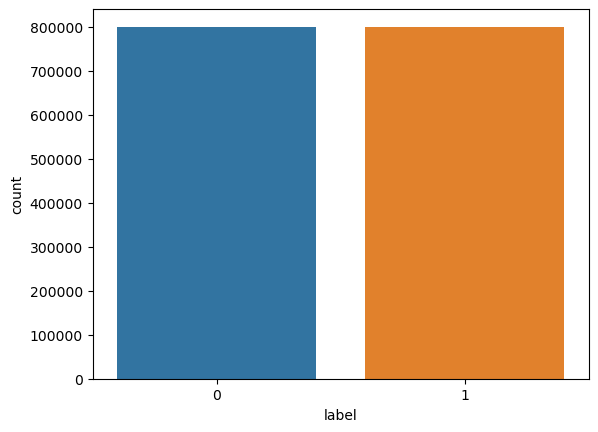

In [5]:
sns.countplot(data=sentiment140, x='label');

## Data Preparation

We will follow the following steps to prepare the data for our model
1. Lowercase the text
2. Remove stopwords from text
3. Remove punctuations from text since that is noise and meaningful information cannot be learned from them
4. Remove usernames, emojis, urls etc.
5. Replace contractions
6. Tokenize the text
7. Perform stemming and lemmatization on text

#### Lowercase the text

In [6]:
sentiment140['text'] = sentiment140['text'].str.lower()

In [7]:
sentiment140.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


#### Remove stopwords from text

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priyangshupal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords

In [12]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
def removeStopwords(text):
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])

In [14]:
test_set = sentiment140[:1000]

In [15]:
test_set['text'] = test_set['text'].apply(lambda line: removeStopwords(line))

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/2320739869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda line: removeStopwords(line))


In [16]:
test_set.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,upset can't update facebook texting it... migh...,0
2,@kenichan dived many times ball. managed save ...,0
3,whole body feels itchy like fire,0
4,"@nationwideclass no, behaving all. i'm mad. he...",0


#### Remove punctuations

In [17]:
import string

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def remove_punctuations(text):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    return text.translate(translator)

In [20]:
test_set['text'] = test_set['text'].apply(lambda line: remove_punctuations(line))

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/3691853927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda line: remove_punctuations(line))


In [21]:
test_set.head()

,text,label
0,switchfoot httptwitpiccom2y1zl awww thats bum...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


#### Remove emails, emojis, urls etc.

In [35]:
import emoji
import re

In [22]:
url_regex = '((www\.[^\s]+)|(https?://[^\s]+))'
username_regex = '@[^\s]+'

In [37]:
def remove_urls(text):
  return re.sub(url_regex, '', text)

def remove_usernames(text):
  return re.sub(username_regex, '', text)

def remove_emojis(text):
  return emoji.demojize(text)

In [38]:
test_set['text'] = test_set['text'].apply(lambda line: remove_urls(line))
test_set['text'] = test_set['text'].apply(lambda line: remove_usernames(line))
test_set['text'] = test_set['text'].apply(lambda line: remove_emojis(line))

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/3097386787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda line: remove_urls(line))
/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/3097386787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda line: remove_usernames(line))
/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/3097386787.py:3: SettingWithCopyWarnin

In [39]:
test_set.head()

,text,label
0,switchfoot httptwitpiccom2y1zl awww thats bum...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


#### Tokenizing the text

In [41]:
from nltk.tokenize import RegexpTokenizer

In [42]:
tokenizer = RegexpTokenizer('\w+')

In [131]:
test_set['text'] = test_set['text'].apply(tokenizer.tokenize)

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/206064492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(tokenizer.tokenize)


In [132]:
test_set.head()

,text,label
0,"[switchfoot, httptwitpiccom2y1zl, awww, that, ...",0
1,"[upset, cant, updat, facebook, text, it, might...",0
2,"[kenichan, dive, mani, time, ball, manag, save...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[nationwideclass, no, behav, all, im, mad, her...",0


### Stemming and Lemmatizing the text

In [45]:
from nltk.stem import PorterStemmer

In [46]:
stemmer = nltk.PorterStemmer()

In [74]:
from nltk.tokenize import word_tokenize

In [138]:
def stemming(text):
  return [stemmer.stem(word) for word in text]

In [141]:
test_set['text'] = test_set['text'].apply(lambda line: stemming(line))

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/2402258884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda line: stemming(line))


In [142]:
test_set.head()

,text,label
0,"[switchfoot, httptwitpiccom2y1zl, awww, that, ...",0
1,"[upset, cant, updat, facebook, text, it, might...",0
2,"[kenichan, dive, mani, time, ball, manag, save...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[nationwideclass, no, behav, all, im, mad, her...",0


In [105]:
lemmatizer = nltk.WordNetLemmatizer()

In [109]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/priyangshupal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/priyangshupal/nltk_data...


True

In [143]:
def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

In [147]:
test_set['text'] = test_set['text'].apply(lambda x: lemmatize(x))

/var/folders/68/bddcm0gs2fn133sxgh69yy2r0000gn/T/ipykernel_12427/1142163831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(lambda x: lemmatize(x))
